In [ ]:
## changed to upload drive
## where our dataset will be present, update data path accordingly
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## system path will be added with current folder's path so import will be successfyl
import sys
sys.path.append('/content/drive/MyDrive/DUCK-Net-main/')

In [ ]:
!pip install keras==2.10.0

In [ ]:
!pip install tensorflow==2.10.0

In [ ]:

%cd /content/drive/MyDrive/DUCK-Net-main/

/content/drive/MyDrive/DUCK-Net-main


In [ ]:
# Importing the necessary libraries

import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import DUCK_Net
from ImageLoader import ImageLoader2D


In [ ]:
import glob

import numpy as np
from PIL import Image
from skimage.io import imread
from tqdm import tqdm
import os


folder_path = "Liver duke processes/"  # Add the path to your data directory


def load_data(img_height, img_width, images_to_be_loaded, dataset):
    IMAGES_PATH = folder_path + 'images/'
    MASKS_PATH = folder_path + 'masks/'

    if dataset == 'kvasir':
        train_ids = glob.glob(IMAGES_PATH + "*.jpg")

    if dataset == 'Liver Duke':
        train_ids = glob.glob(IMAGES_PATH + "*.jpg")

    if dataset == 'cvc-clinicdb':
        train_ids = glob.glob(IMAGES_PATH + "*.tif")

    if dataset == 'cvc-colondb' or dataset == 'etis-laribpolypdb':
        train_ids = glob.glob(IMAGES_PATH + "*.png")

    if images_to_be_loaded == -1:
        images_to_be_loaded = 1500#len(train_ids)##earlier 10 #train_ids

    X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y_train = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print('Resizing training images and masks: ' + str(images_to_be_loaded))
    for n, id_ in tqdm(enumerate(train_ids)):#train_ids
        if n == images_to_be_loaded:
            break

        image_path = id_
        mask_path = image_path.replace("images", "masks")

        image = imread(image_path)
        #mask_ = imread(mask_path)
        mask_ = imread(mask_path)

        mask = np.zeros((img_height, img_width), dtype=np.bool_)

        pillow_image = Image.fromarray(image)

        pillow_image = pillow_image.resize((img_height, img_width))
        image = np.array(pillow_image)

        X_train[n] = image / 255



        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)

        for i in range(img_height):
            for j in range(img_width):
                if (mask_[i, j] >= 127):
                    mask[i, j] = 1

        Y_train[n] = mask

    Y_train = np.expand_dims(Y_train, axis=-1)

    return X_train, Y_train


In [ ]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Setting the model parameters

img_size = 352
dataset_type = 'Liver Duke' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 17 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

ct = datetime.now()

model_type = "DuckNet"

progress_path = 'ProgressFull/' + dataset_type + '_progress_csv_' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + dataset_type + '_progress_' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + dataset_type + '_progress_plot_' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + dataset_type + '/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 600
min_loss_for_saving = 0.3

In [ ]:
%cd /content/drive/MyDrive/DUCK-Net-main/ImageLoader

/content/drive/MyDrive/DUCK-Net-main/ImageLoader


In [ ]:
# Loading the data

X, Y = load_data(img_size, img_size, -1, 'Liver Duke')

Resizing training images and masks: 1500


1500it [09:54,  2.52it/s]


Dimensions of the selected image: 352 x 352


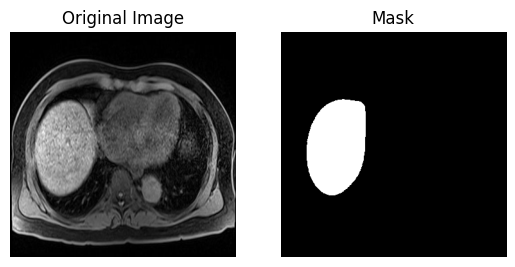

In [ ]:
import matplotlib.pyplot as plt

# Assuming X is a list/array of images and Y is the corresponding masks
# Let's say you want to visualize the first image and its mask:
image_to_display = X[8]
mask_to_display = Y[8]





# Get the dimensions of the image
height, width = image_to_display.shape[:2]
print(f'Dimensions of the selected image: {width} x {height}')


# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image_to_display)
plt.title('Original Image')
plt.axis('off')

# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_to_display, cmap='gray',vmin=0,vmax = 1)  # Assuming masks are in grayscale
plt.title('Mask')
plt.axis('off')

plt.show()


In [ ]:


# Splitting the data, seed for reproducibility

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)

In [ ]:
# Defining the augmentations
import cv2

aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),


])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        ug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [ ]:
# Creating the model

model = DUCK_Net.create_model(img_height=img_size, img_width=img_size, input_chanels=3, out_classes=1, starting_filters=filters)

Starting DUCK-Net


In [ ]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [ ]:
%cd /content/drive/MyDrive/DUCK-Net-main

/content/drive/MyDrive/DUCK-Net-main


In [ ]:
from tensorflow.python.framework import tensor_util
def is_tensor(x):
    return tensor_util.is_tensor(x)
    #return isinstance(x, tf_ops._TensorLike) or tf_ops.is_dense_tensor_like(x)

In [ ]:
!nvidia-smi
min_loss_for_saving=0.6

Mon Nov 20 05:39:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W /  70W |    555MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Training the model



step = 0

for epoch in range(0,11):#200 kariyo later

    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1

    image_augmented, mask_augmented = augment_images()

    csv_logger = CSVLogger(progress_path, append=True, separator=';')

    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=3, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])#batch size increse kar sakti to increse accuracy
#earlier batch size = 4
    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)

    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))

    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))

    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')

    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save("DUCK-Net-main/ModelSaveTensorFlow/liver.h5")#isko under if karna tha originally

    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
400/400 [==============================] - 383s 771ms/step - loss: 0.8352 - val_loss: 0.9625
Loss Validation: 0.96147853
Loss Test: 0.9619266
Training, epoch 1
Learning Rate: 0.0001
400/400 [==============================] - 304s 759ms/step - loss: 0.7861 - val_loss: 0.7820
Loss Validation: 0.74315345
Loss Test: 0.75736773
Training, epoch 2
Learning Rate: 0.0001
400/400 [==============================] - 304s 759ms/step - loss: 0.7436 - val_loss: 0.7817
Loss Validation: 0.7531979
Loss Test: 0.80392396
Training, epoch 3
Learning Rate: 0.0001
400/400 [==============================] - 303s 758ms/step - loss: 0.7152 - val_loss: 0.6288
Loss Validation: 0.55977106
Loss Test: 0.58558565
Saved model with val_loss:  0.55977106
Training, epoch 4
Learning Rate: 0.0001
400/400 [==============================] - 303s 758ms/step - loss: 0.6880 - val_loss: 0.6439
Loss Validation: 0.59636474
Loss Test: 0.6259522
Training, epoch 5
Learning Rate: 0.0001
400/400 [

In [ ]:
# Computing the metrics and saving the results
from ModelArchitecture.DiceLoss import dice_metric_loss

print("Loading the model")

model_path = "DUCK-Net-main/ModelSaveTensorFlow/liver.h5"#earlier kvasir


model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})



prediction_train = model.predict(x_train, batch_size=3)#earlier 4
prediction_valid = model.predict(x_valid, batch_size=3)#4
prediction_test = model.predict(x_test, batch_size=3)#4

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")


final_file = 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')

Loading the model
50/50 [==============================] - 10s 195ms/step
Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
results_DuckNet_17_Liver Duke.txt
File done


In [ ]:
#cd ../ ->to go one directory up

In [ ]:
#ways to increse accuracy
#Implementing learning rate schedulers like OneCycleLR or ReduceLROnPlateau in your deep learning model typically involves using popular deep learning frameworks like PyTorch or TensorFlow. Below, I'll provide examples for both frameworks:

#PyTorch:

*#ways to increse accuracy
#Implementing learning rate schedulers like OneCycleLR or ReduceLROnPlateau in your deep learning model typically involves using popular deep learning frameworks like PyTorch or TensorFlow. Below, I'll provide examples for both frameworks:

#PyTorch:*
OneCycleLR:
OneCycleLR is a learning rate scheduler that varies the learning rate during training. To implement it in PyTorch, you can use the following code:

python

import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import OneCycleLR

# Define your model, optimizer, and dataloader
model = ...
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
dataloader = ...

# Create the OneCycleLR scheduler
scheduler = OneCycleLR(optimizer, max_lr=0.1, total_steps=1000)

# Inside your training loop
for epoch in range(num_epochs):
    for batch in dataloader:
        # Forward and backward passes
        optimizer.step()
        optimizer.zero_grad()
        
        # Step the OneCycleLR scheduler
        scheduler.step()


In [ ]:
#ReduceLROnPlateau:
#ReduceLROnPlateau is used to reduce the learning rate when a certain condition (e.g., validation loss plateau) is met. Here's an example:
#import torch
#from torch.optim import SGD
#from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define your model, optimizer, and dataloader
#model = ...
#optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
#dataloader = ...

# Create the ReduceLROnPlateau scheduler
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Inside your training loop
#for epoch in range(num_epochs):
    #for batch in dataloader:
        # Forward and backward passes
        #optimizer.step()
        #optimizer.zero_grad()

    # Calculate validation loss
    #val_loss = validate_model(model, val_dataloader)  # Implement your validation function

    # Step the ReduceLROnPlateau scheduler based on validation loss
    #scheduler.step(val_loss)


Hyperparameter Optimization:

Use tools like Bayesian optimization or grid search to fine-tune hyperparameters more efficiently.

Fine-tuning hyperparameters using tools like Bayesian optimization or grid search can significantly improve the performance of your machine learning models. Here's how to use these techniques:

Grid Search:
Grid search is a simple and widely used hyperparameter tuning technique. It involves defining a range of hyperparameters and exhaustively trying all possible combinations. Here's how you can perform grid search using Python and scikit-learn:

*****
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1]
}

# Create the model
svm = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
grid_search.fit(X, y)  # X and y are your data and labels

# Get the best hyperparameters
best_params = grid_search.best_params_

Bayesian Optimization:
Bayesian optimization is a more sophisticated method that uses probabilistic models to guide the search for the best hyperparameters. The scikit-optimize library is a popular choice for Bayesian optimization in Python:

python

*****
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Define the search space for hyperparameters
search_space = {
    'C': Real(0.1, 10.0, prior='log-uniform'),
    'kernel': Categorical(['linear', 'rbf']),
    'gamma': Real(0.001, 0.1, prior='log-uniform')
}

# Create the model
svm = SVC()

# Perform Bayesian optimization with cross-validation
bayes_search = BayesSearchCV(estimator=svm, search_spaces=search_space, cv=5, n_iter=50, random_state=42)
bayes_search.fit(X, y)  # X and y are your data and labels

# Get the best hyperparameters
best_params = bayes_search.best_params_
